<a href="https://colab.research.google.com/github/ozakiryota/kaggle/blob/main/store_sales/store_sales_fc_merged_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downlad and check datasets

Activate Kaggle API

In [ ]:
from google.colab import files
import os

jason_path = "/root/.kaggle/kaggle.json"

if not os.path.exists(jason_path):
    uploaded = files.upload()

    for fn in uploaded.keys():
        print("User uploaded file '{name}' with length {length} bytes".format(
            name=fn, length=len(uploaded[fn])))

    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p /root/.kaggle/ && mv kaggle.json /root/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

else:
    print(jason_path, "is already exists.")

/root/.kaggle/kaggle.json is already exists.


Download the datasets

In [ ]:
!pip install kaggle
!kaggle competitions download -c store-sales-time-series-forecasting
!unzip -n train.csv.zip
!unzip -n transactions.csv.zip

holidays_events.csv: Skipping, found more recently modified local copy (use --force to force download)
stores.csv: Skipping, found more recently modified local copy (use --force to force download)
oil.csv: Skipping, found more recently modified local copy (use --force to force download)
transactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
Archive:  transactions.csv.zip


Check the datasets

In [ ]:
import pandas as pd

df = pd.read_csv("/content/train.csv")
# df = pd.read_csv("/content/test.csv")
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


# Fuctions and class

In [ ]:
import pandas as pd

def makeDataList(main_csv_path_list, oil_csv_path, holiday_csv_path):
    datalist = pd.DataFrame()
    for path in main_csv_path_list:
        datalist = pd.concat([datalist, pd.read_csv(path)], ignore_index=True)
    
    datalist = datalist.drop("id", axis=1).set_index(["date", "store_nbr", "family"]).sort_index().unstack(["store_nbr", "family"])

    datalist = pd.merge(datalist, pd.read_csv(oil_csv_path), on="date", how="left")
    datalist["dcoilwtico"] = datalist["dcoilwtico"].fillna(datalist["dcoilwtico"].mean())
    datalist = pd.merge(datalist, pd.read_csv(holiday_csv_path), on="date", how="left").drop(["locale_name", "description"], axis=1)
    datalist["type"] = datalist["type"].fillna("NA")
    datalist["locale"] = datalist["locale"].fillna("NA")
    datalist["transferred"] = datalist["transferred"].fillna("NA")

    # datalist["date"] = pd.to_datetime(datalist["date"])
    datalist = datalist.drop("date", axis=1)
    datalist = pd.get_dummies(datalist)

    return datalist

In [ ]:
## TEST
datalist = makeDataList(["/content/train.csv"], "/content/oil.csv", "/content/holidays_events.csv")
print("datalist.columns =\n", datalist.columns)
print("datalist.values[0] =", datalist.values[0])
datalist

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


datalist.columns =
 Index([  ('sales', 1, 'AUTOMOTIVE'),    ('sales', 1, 'BABY CARE'),
             ('sales', 1, 'BEAUTY'),    ('sales', 1, 'BEVERAGES'),
              ('sales', 1, 'BOOKS'), ('sales', 1, 'BREAD/BAKERY'),
        ('sales', 1, 'CELEBRATION'),     ('sales', 1, 'CLEANING'),
              ('sales', 1, 'DAIRY'),         ('sales', 1, 'DELI'),
       ...
                          'type_NA',              'type_Transfer',
                    'type_Work Day',               'locale_Local',
                        'locale_NA',            'locale_National',
                  'locale_Regional',          'transferred_False',
                 'transferred_True',             'transferred_NA'],
      dtype='object', length=3579)
datalist.values[0] = [0. 0. 0. ... 1. 0. 0.]


,"(sales, 1, AUTOMOTIVE)","(sales, 1, BABY CARE)","(sales, 1, BEAUTY)","(sales, 1, BEVERAGES)","(sales, 1, BOOKS)","(sales, 1, BREAD/BAKERY)","(sales, 1, CELEBRATION)","(sales, 1, CLEANING)","(sales, 1, DAIRY)","(sales, 1, DELI)","(sales, 1, EGGS)","(sales, 1, FROZEN FOODS)","(sales, 1, GROCERY I)","(sales, 1, GROCERY II)","(sales, 1, HARDWARE)","(sales, 1, HOME AND KITCHEN I)","(sales, 1, HOME AND KITCHEN II)","(sales, 1, HOME APPLIANCES)","(sales, 1, HOME CARE)","(sales, 1, LADIESWEAR)","(sales, 1, LAWN AND GARDEN)","(sales, 1, LINGERIE)","(sales, 1, LIQUOR,WINE,BEER)","(sales, 1, MAGAZINES)","(sales, 1, MEATS)","(sales, 1, PERSONAL CARE)","(sales, 1, PET SUPPLIES)","(sales, 1, PLAYERS AND ELECTRONICS)","(sales, 1, POULTRY)","(sales, 1, PREPARED FOODS)","(sales, 1, PRODUCE)","(sales, 1, SCHOOL AND OFFICE SUPPLIES)","(sales, 1, SEAFOOD)","(sales, 2, AUTOMOTIVE)","(sales, 2, BABY CARE)","(sales, 2, BEAUTY)","(sales, 2, BEVERAGES)","(sales, 2, BOOKS)","(sales, 2, BREAD/BAKERY)","(sales, 2, CELEBRATION)",...,"(onpromotion, 54, DAIRY)","(onpromotion, 54, DELI)","(onpromotion, 54, EGGS)","(onpromotion, 54, FROZEN FOODS)","(onpromotion, 54, GROCERY I)","(onpromotion, 54, GROCERY II)","(onpromotion, 54, HARDWARE)","(onpromotion, 54, HOME AND KITCHEN I)","(onpromotion, 54, HOME AND KITCHEN II)","(onpromotion, 54, HOME APPLIANCES)","(onpromotion, 54, HOME CARE)","(onpromotion, 54, LADIESWEAR)","(onpromotion, 54, LAWN AND GARDEN)","(onpromotion, 54, LINGERIE)","(onpromotion, 54, LIQUOR,WINE,BEER)","(onpromotion, 54, MAGAZINES)","(onpromotion, 54, MEATS)","(onpromotion, 54, PERSONAL CARE)","(onpromotion, 54, PET SUPPLIES)","(onpromotion, 54, PLAYERS AND ELECTRONICS)","(onpromotion, 54, POULTRY)","(onpromotion, 54, PREPARED FOODS)","(onpromotion, 54, PRODUCE)","(onpromotion, 54, SCHOOL AND OFFICE SUPPLIES)","(onpromotion, 54, SEAFOOD)",dcoilwtico,type_Additional,type_Bridge,type_Event,type_Holiday,type_NA,type_Transfer,type_Work Day,locale_Local,locale_NA,locale_National,locale_Regional,transferred_False,transferred_True,transferred_NA
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.925589,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,2.0,0.0,2.0,1091.0,0.0,470.65200,0.0,1060.0,579.0,164.069,246.0,131.000,2652.0,31.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,13.0,67.0,0.0,369.10100,194.0,0.0,0.0,247.29700,47.000000,0.000,0.0,38.029000,8.0,0.0,3.0,1481.0,0.0,523.882,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93.140000,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,3.0,0.0,0.0,919.0,0.0,310.65500,0.0,836.0,453.0,151.582,203.0,87.044,2121.0,12.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,15.0,66.0,0.0,272.31900,153.0,0.0,0.0,187.27800,63.000000,0.000,0.0,17.366001,5.0,0.0,2.0,1016.0,0.0,321.693,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92.970000,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,3.0,0.0,3.0,953.0,0.0,198.36600,0.0,827.0,460.0,131.411,171.0,65.000,2056.0,15.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,24.0,102.0,0.0,454.17200,88.0,0.0,0.0,258.02300,67.000000,0.000,0.0,29.907001,3.0,0.0,3.0,1146.0,0.0,299.012,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93.120000,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,5.0,0.0,3.0,1160.0,0.0,301.05700,0.0,811.0,464.0,118.613,177.0,70.000,2216.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,20.0,159.0,0.0,328.94000,141.0,0.0,0.0,212.33301,66.000000,0.000,0.0,24.842000,5.0,0.0,9.0,1581.0,0.0,385.333,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.925589,0,0,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,1.0,0.0,1.0,1006.0,0.0,145.60700,4.0,341.0,343.0,64

In [ ]:
def getSaleColumns(datalist):
    sale_columns = []
    for col in datalist.columns:
        if col[0] == "sales":
            sale_columns.append(col)
    return sale_columns

In [ ]:
## TEST
print(getSaleColumns(datalist))

[('sales', 1, 'AUTOMOTIVE'), ('sales', 1, 'BABY CARE'), ('sales', 1, 'BEAUTY'), ('sales', 1, 'BEVERAGES'), ('sales', 1, 'BOOKS'), ('sales', 1, 'BREAD/BAKERY'), ('sales', 1, 'CELEBRATION'), ('sales', 1, 'CLEANING'), ('sales', 1, 'DAIRY'), ('sales', 1, 'DELI'), ('sales', 1, 'EGGS'), ('sales', 1, 'FROZEN FOODS'), ('sales', 1, 'GROCERY I'), ('sales', 1, 'GROCERY II'), ('sales', 1, 'HARDWARE'), ('sales', 1, 'HOME AND KITCHEN I'), ('sales', 1, 'HOME AND KITCHEN II'), ('sales', 1, 'HOME APPLIANCES'), ('sales', 1, 'HOME CARE'), ('sales', 1, 'LADIESWEAR'), ('sales', 1, 'LAWN AND GARDEN'), ('sales', 1, 'LINGERIE'), ('sales', 1, 'LIQUOR,WINE,BEER'), ('sales', 1, 'MAGAZINES'), ('sales', 1, 'MEATS'), ('sales', 1, 'PERSONAL CARE'), ('sales', 1, 'PET SUPPLIES'), ('sales', 1, 'PLAYERS AND ELECTRONICS'), ('sales', 1, 'POULTRY'), ('sales', 1, 'PREPARED FOODS'), ('sales', 1, 'PRODUCE'), ('sales', 1, 'SCHOOL AND OFFICE SUPPLIES'), ('sales', 1, 'SEAFOOD'), ('sales', 2, 'AUTOMOTIVE'), ('sales', 2, 'BABY CAR

In [ ]:
## TEST
from sklearn.model_selection import train_test_split

train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)
print(train_datalist)
print(val_datalist)

      (sales, 1, AUTOMOTIVE)  ...  transferred_NA
1324                     0.0  ...               1
813                      3.0  ...               1
1632                     6.0  ...               1
181                      0.0  ...               1
1381                     5.0  ...               1
...                      ...  ...             ...
1228                    12.0  ...               0
1077                     1.0  ...               1
1318                     5.0  ...               1
723                      7.0  ...               1
815                      3.0  ...               1

[1542 rows x 3579 columns]
      (sales, 1, AUTOMOTIVE)  ...  transferred_NA
1016                     4.0  ...               1
1541                     2.0  ...               0
454                      4.0  ...               1
889                      1.0  ...               1
222                      5.0  ...               1
...                      ...  ...             ...
878                   

In [ ]:
import numpy as np

import torch.utils.data as data

class DatasetMaker(data.Dataset):
    def __init__(self, datalist):
        sale_columns = getSaleColumns(datalist)

        self.input_datalist = datalist.drop(sale_columns, axis=1).values.astype(np.float32)
        self.label_datalist = datalist[sale_columns].values.astype(np.float32)

    def __len__(self):
        return len(self.input_datalist)
    
    def __getitem__(self, index):
        inputs = self.input_datalist[index]
        labels = self.label_datalist[index]
        return inputs, labels

In [ ]:
## TEST
dataset = DatasetMaker(datalist)
inputs0 = dataset.__getitem__(index=0)[0]
labels0 = dataset.__getitem__(index=0)[1]
print("dataset.__len__() =", dataset.__len__())
print("labels0 =\n", labels0)
print("labels0.shape =", labels0.shape)
print("inputs0 =\n", inputs0)
print("inputs0.shape =", inputs0.shape)

dataset.__len__() = 1714
labels0 =
 [0. 0. 0. ... 0. 0. 0.]
labels0.shape = (1782,)
inputs0 =
 [0. 0. 0. ... 1. 0. 0.]
inputs0.shape = (1797,)


In [ ]:
## TEST
import torch

batch_size = 10
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
batch_itr = iter(dataloader)
inputs, labels = next(batch_itr)

# print("inputs =\n", inputs)
print("inputs.size() =", inputs.size())
print("labels =\n", labels)
print("labels.size() =", labels.size())

inputs.size() = torch.Size([10, 1797])
labels =
 tensor([[  5.0000,   0.0000,   4.0000,  ..., 629.6440,   0.0000,   5.0000],
        [  5.0000,   0.0000,   2.0000,  ...,   0.0000,   0.0000,   2.0000],
        [  2.0000,   0.0000,   5.0000,  ..., 506.9870,   1.0000,   2.0000],
        ...,
        [  2.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   2.0000],
        [  4.0000,   0.0000,   3.0000,  ..., 506.6830,   0.0000,   1.0000],
        [  1.0000,   0.0000,   1.0000,  ..., 761.4030,   0.0000,   1.0000]])
labels.size() = torch.Size([10, 1782])


In [ ]:
from torch import nn

class Network(nn.Module):
    def __init__(self, fc_dim_list, dropout_rate):
        super().__init__()

        layer_list = []
        for i in range(len(fc_dim_list) - 1):
            layer_list.append(nn.Linear(fc_dim_list[i], fc_dim_list[i+1]))
            if i != len(fc_dim_list) - 2:
                layer_list.append(nn.ReLU(inplace=True))
                layer_list.append(nn.Dropout(p=dropout_rate))
        self.fc = nn.Sequential(*layer_list)

    def forward(self, x):
        x = self.fc(x)
        return x

In [ ]:
## TEST
net = Network(
    fc_dim_list = [dataset.__getitem__(index=0)[0].shape[0], 256, 256, dataset.__getitem__(index=0)[1].shape[0]],
    dropout_rate = 0.1
)
print(net)
outputs = net(inputs)
print("outputs =\n", outputs)
print("outputs.size() =", outputs.size())

Network(
  (fc): Sequential(
    (0): Linear(in_features=1797, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=1782, bias=True)
    (7): ReLU(inplace=True)
  )
)
outputs =
 tensor([[1.2826, 0.0000, 0.0000,  ..., 0.2366, 0.1969, 0.0000],
        [0.0260, 0.0000, 0.0000,  ..., 0.0030, 0.0459, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0652, 0.1690, 0.1637,  ..., 0.0000, 0.0871, 0.0000],
        [0.0000, 1.2294, 0.0000,  ..., 0.0000, 0.0157, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
outputs.size() = torch.Size([10, 1782])


# Training

self.device =  cpu


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Network(
  (fc): Sequential(
    (0): Linear(in_features=1797, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=1782, bias=True)
    (10): ReLU(inplace=True)
  )
)
----------
Epoch 1/1000
train Loss: 1130980.8292
val Loss: 713483.4549
----------
Epoch 100/1000
train Loss: 103651.6510
val Loss: 116650.0977
----------
Epoch 200/1000
train Loss: 79873.1911
val Loss: 107384.7852
----------
Epoch 300/1000
train Loss: 66476.9039
val Loss: 101268.3270
----------
Epoch 400/1000
train Loss: 62879.2727
val Loss: 99625.2934
----------
Epoch 500/1000
train Loss: 58975.5635
val Loss: 100827.7433
----------
Epoch 600/1000
train Loss: 58428.6091
val Loss: 

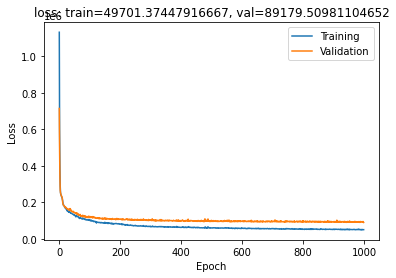

In [ ]:
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

class Trainer:
    def __init__(self, train_csv_path, oil_csv_path, holiday_csv_path, num_epochs, batch_size, lr, save_weights_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("self.device = ", self.device)

        self.num_epochs = num_epochs
        self.save_weights_path = save_weights_path

        datalist = makeDataList([train_csv_path], oil_csv_path, holiday_csv_path)
        train_datalist, val_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)
        train_dataset = DatasetMaker(train_datalist)
        val_dataset = DatasetMaker(val_datalist)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        
        self.dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
        self.net = Network(
            fc_dim_list = [dataset.__getitem__(index=0)[0].shape[0], 512, 512, 512, dataset.__getitem__(index=0)[1].shape[0]],
            dropout_rate = 0.1
        )
        self.net.to(self.device)
        print(self.net)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def train(self):
        ## time
        start_clock = time.time()
        ## record
        record_loss_dict = {"train": [], "val": []}
        min_loss_epoch = 0.0
        ## loop
        for epoch in range(self.num_epochs):
            if epoch == 0 or not (epoch+1) % (num_epochs // 10):
                print("----------")
                print("Epoch {}/{}".format(epoch+1, self.num_epochs))
            ## phase
            for phase in ["train", "val"]:
                ## setting
                if phase == "train":
                    self.net.train()
                else:
                    self.net.eval()
                ## buffer
                loss_epoch = 0.0
                num_inputs_epoch = 0
                for inputs, labels in self.dataloaders_dict[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    ## reset gradient
                    self.optimizer.zero_grad()
                    ## switch computing gradient
                    with torch.set_grad_enabled(phase == "train"):
                        ## forward
                        outputs = self.net(inputs)
                        loss = self.criterion(outputs, labels)
                        ## backward
                        if phase == "train":
                            loss.backward()
                            self.optimizer.step()
                    ## add
                    loss_epoch += loss.item() * inputs.size(0)
                    num_inputs_epoch += inputs.size(0)
                ## average loss
                loss_epoch = loss_epoch / num_inputs_epoch
                record_loss_dict[phase].append(loss_epoch)
                if epoch == 0 or not (epoch+1) % (num_epochs // 10):
                    print("{} Loss: {:.4f}".format(phase, loss_epoch))
            ## save
            if epoch == 0 or record_loss_dict["val"][-1] < min_loss_epoch:
                min_loss_epoch = record_loss_dict["val"][-1]
                torch.save(self.net.state_dict(), self.save_weights_path)
        ## time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ("training time: ", mins, " [min] ", secs, " [sec]")
        ## graph
        self.showGraph(record_loss_dict)

    def showGraph(self, record_loss_dict):
        graph = plt.figure()
        plt.plot(range(len(record_loss_dict["train"])), record_loss_dict["train"], label="Training")
        plt.plot(range(len(record_loss_dict["val"])), record_loss_dict["val"], label="Validation")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("loss: train=" + str(record_loss_dict["train"][-1]) + ", val=" + str(record_loss_dict["val"][-1]))
        plt.show()

train_csv_path = "/content/train.csv"
oil_csv_path = "/content/oil.csv"
holiday_csv_path = "/content/holidays_events.csv"
num_epochs = 1000
batch_size = 100
lr = 0.001
save_weights_path = "/content/weights.pth"

trainer = Trainer(train_csv_path, oil_csv_path, holiday_csv_path, num_epochs, batch_size, lr, save_weights_path)
trainer.train()

# Evaluation

In [ ]:
import time
import pandas as pd

import torch

class Evaluator:
    def __init__(self, train_csv_path, test_csv_path, oil_csv_path, holiday_csv_path, weights_path, save_csv_path):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("self.device = ", self.device)

        self.test_csv_path = test_csv_path
        self.save_csv_path = save_csv_path
        self.datalist = makeDataList([train_csv_path, test_csv_path], oil_csv_path, holiday_csv_path)
        sale_columns = getSaleColumns(self.datalist)
        self.datalist = self.datalist.loc[self.datalist[sale_columns[0]].isna()].drop(sale_columns, axis=1)

        self.net = Network(
            fc_dim_list = [dataset.__getitem__(index=0)[0].shape[0], 512, 512, 512, dataset.__getitem__(index=0)[1].shape[0]],
            dropout_rate = 0.1
        )
        self.net.to(self.device)
        if torch.cuda.is_available():
            loaded_weights = torch.load(weights_path)
            print("Weights have been loaded [GPU -> GPU]:", weights_path)
        else:
            loaded_weights = torch.load(weights_path, map_location={"cuda:0": "cpu"})
            print("Weights have been loaded [GPU -> CPU]:", weights_path)
        self.net.load_state_dict(loaded_weights)
        print(self.net)

    def evaluate(self):
        ## time
        start_clock = time.time()
        ## setting
        self.net.eval()
        ## ndarray -> tensor
        inputs = torch.from_numpy(self.datalist.values.astype(np.float32))
        inputs = inputs.to(self.device)
        ## forward
        with torch.no_grad():
            outputs = self.net(inputs)
        ## save
        self.writeCSV(outputs)
        ## time
        mins = (time.time() - start_clock) // 60
        secs = (time.time() - start_clock) % 60
        print ("evaluation time: ", mins, " [min] ", secs, " [sec]")

    def writeCSV(self, outputs):
        result_df = pd.DataFrame({"id": pd.read_csv(self.test_csv_path)["id"].values, "sales": outputs.cpu().detach().numpy().reshape(-1)})
        result_df.to_csv(self.save_csv_path, index=False)
        print(result_df)


train_csv_path = "/content/train.csv"
test_csv_path = "/content/test.csv"
oil_csv_path = "/content/oil.csv"
holiday_csv_path = "/content/holidays_events.csv"

weights_path = "/content/weights.pth"
save_csv_path = "/content/submission.csv"

evaluator = Evaluator(train_csv_path, test_csv_path, oil_csv_path, holiday_csv_path, weights_path, save_csv_path)
evaluator.evaluate()

self.device =  cpu


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Weights have been loaded [GPU -> CPU]: /content/weights.pth
Network(
  (fc): Sequential(
    (0): Linear(in_features=1797, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=1782, bias=True)
    (10): ReLU(inplace=True)
  )
)
            id        sales
0      3000888     0.000000
1      3000889     0.000000
2      3000890     0.000000
3      3000891  4361.116699
4      3000892     0.000000
...        ...          ...
28507  3029395     0.000000
28508  3029396     0.000000
28509  3029397   668.297241
28510  3029398     0.000000
28511  3029399     0.000000

[28512 rows x 2 columns]
evaluation time:  0.0  [min]  0.08495044708251953  [sec]


# Submission

In [ ]:
import sys

print("Submit the file? (y/n)")
ans = input()
while ans != "y" and ans != "n":
    print("Type 'y' or 'n'")
    ans = input()
if ans == "y":
    !kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "store_sales_fc_merged_data.ipynb"

Submit the file? (y/n)
